In [1]:
# 1. Imports
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

/Users/crobison/workspace/ds-sales-forcasting/sales_forecast_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [14]:
# 2. Connect to DuckDB
con = duckdb.connect(database='../data/dev.duckdb', read_only=False)

In [15]:
# 3. Preview tables
print("Available tables:")
tables = con.execute("SHOW TABLES").fetchall()
for t in tables:
    print("-", t[0])

Available tables:
- dim_customers
- dim_products
- fct_sales
- sales_data
- stg_sales


In [16]:
# 4. Load fact and dimension tables
fct_sales = con.execute("SELECT * FROM fct_sales").fetchdf()
dim_customers = con.execute("SELECT * FROM dim_customers").fetchdf()
dim_products = con.execute("SELECT * FROM dim_products").fetchdf()

In [17]:
# 5. Join fact with dimensions
sales_full = fct_sales.merge(dim_customers, on='customer_id', how='left')
sales_full = sales_full.merge(dim_products, on='product_id', how='left')

In [18]:
# 6. Convert date column
sales_full['sale_date'] = pd.to_datetime(sales_full['sale_date'])

In [19]:
# 7. Total sales per month
monthly_sales = sales_full.groupby(sales_full['sale_date'].dt.to_period('M'))['sales_amount'].sum()
monthly_sales = monthly_sales.reset_index()
monthly_sales['sale_date'] = monthly_sales['sale_date'].dt.to_timestamp()

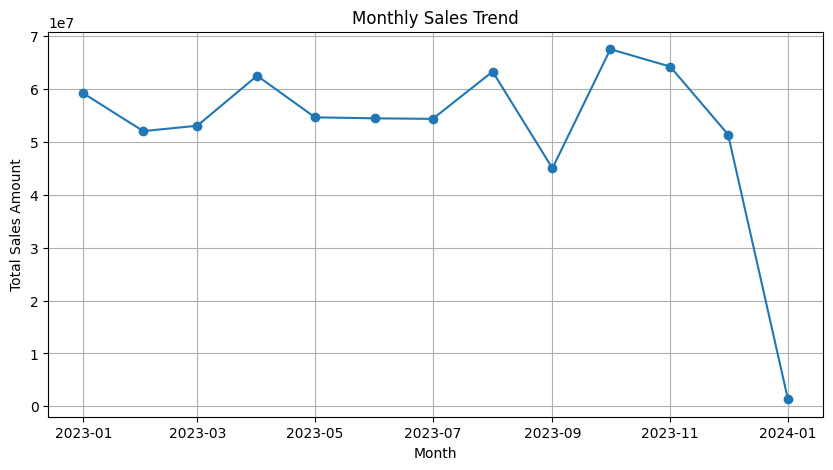

In [20]:
# 8. Plot overall sales trend
plt.figure(figsize=(10,5))
plt.plot(monthly_sales['sale_date'], monthly_sales['sales_amount'], marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales Amount")
plt.grid(True)
plt.show()

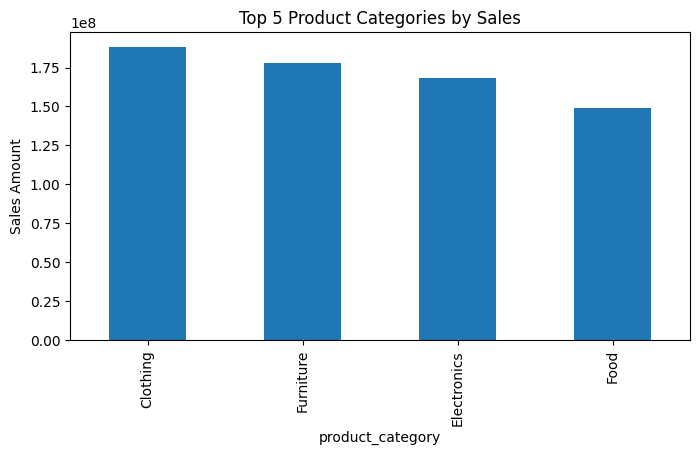

In [21]:
# 9. Top 5 product categories
top_products = sales_full.groupby('product_category')['sales_amount'].sum().sort_values(ascending=False).head(5)
top_products.plot(kind='bar', figsize=(8,4), title='Top 5 Product Categories by Sales')
plt.ylabel('Sales Amount')
plt.show()

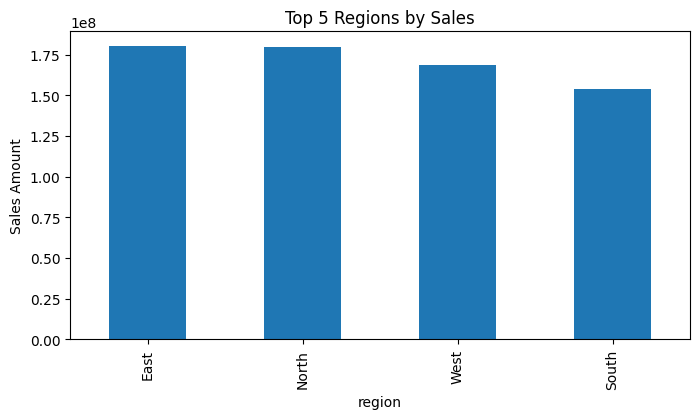

In [22]:
# 10. Top 5 regions
top_regions = sales_full.groupby('region')['sales_amount'].sum().sort_values(ascending=False).head(5)
top_regions.plot(kind='bar', figsize=(8,4), title='Top 5 Regions by Sales')
plt.ylabel('Sales Amount')
plt.show()

In [24]:
# 11. Forecast overall monthly sales using Prophet
prophet_df = monthly_sales.rename(columns={'sale_date': 'ds', 'sales_amount': 'y'})
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(prophet_df)

future = m.make_future_dataframe(periods=3, freq='M')  # forecast next 3 months
forecast = m.predict(future)

19:53:31 - cmdstanpy - INFO - Chain [1] start processing
19:53:31 - cmdstanpy - INFO - Chain [1] done processing
/Users/crobison/workspace/ds-sales-forcasting/sales_forecast_env/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


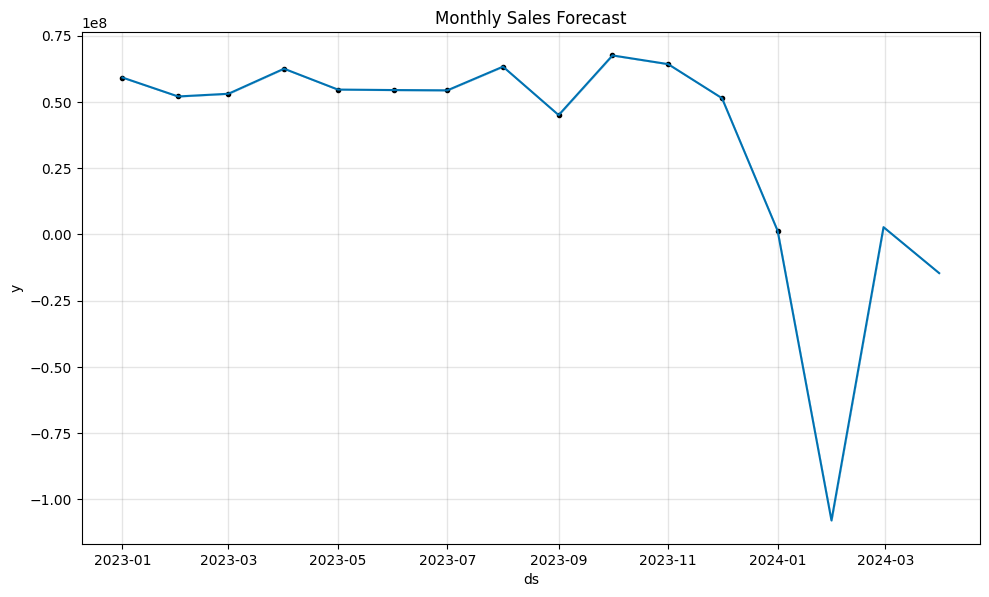

In [25]:
# 12. Plot forecast
fig1 = m.plot(forecast)
plt.title("Monthly Sales Forecast")
plt.show()

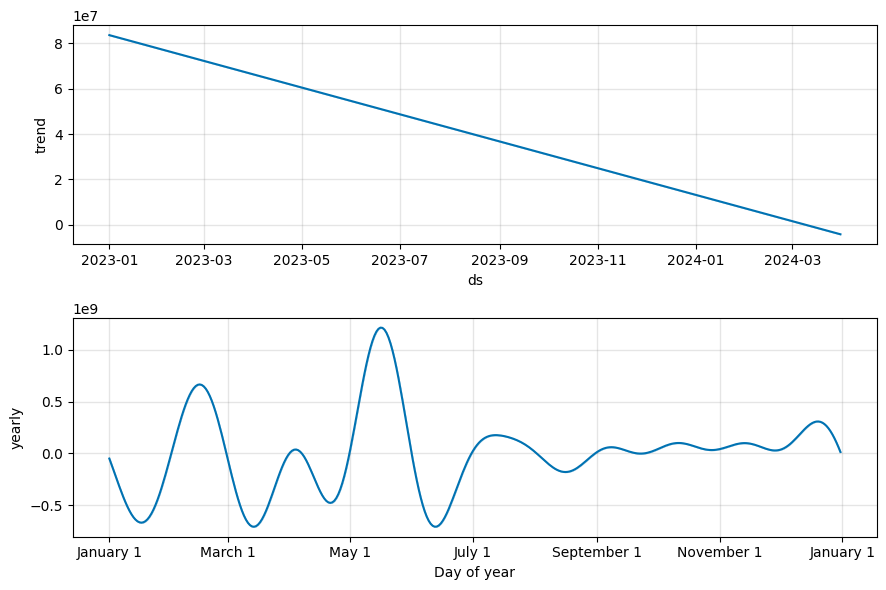

In [26]:
# 13. Optional: Plot forecast components
fig2 = m.plot_components(forecast)
plt.show()

In [27]:
con.close()